<h1>Overview</h1>
<p>Suppose we have an <code>rxd.Reaction</code> or <code>rxd.Rate</code> that should only occur when the concentration is above (or below) a certain threshold. These functions, however, only support continuous rate functions. What can we do?</p>

In [1]:
%matplotlib inline

One approach is to use a <a href="https://en.wikipedia.org/wiki/Sigmoid_function">sigmoid function</a> such as $\tanh(x)$:

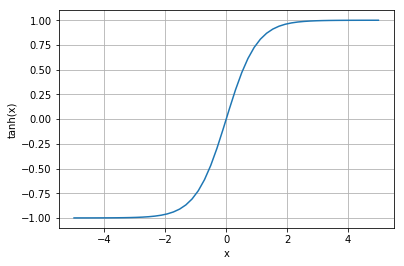

In [8]:
from matplotlib import pyplot as plt
import numpy
x = numpy.linspace(-5, 5)
y = numpy.tanh(x)
plt.grid()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.show()

Consider the following transformation of $\tanh(x)$:

$$f(x) = \frac{1 + \tanh(2m(x-a))}{2}$$

One can show that
$\displaystyle \lim_{x \to \infty} f(x) = 1$,
$\displaystyle \lim_{x \to -\infty} f(x) = 0$,
$\displaystyle f(a) = 0.5,$ and 
$\displaystyle f'(a) = m$. Furthermore $f$ is a sigmoid function that shifts between $0$ and $1$ arbitrarily quickly (parameterized by $m$) around $x=a$.


Here, for example, is the graph of $\displaystyle g(x) = \frac{1 + \tanh(2\cdot 10(x-2))}{2}$:

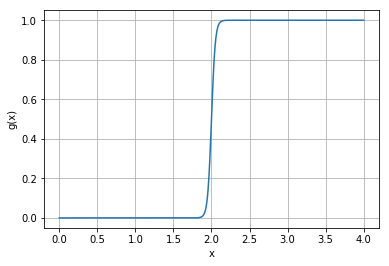

In [19]:
x = numpy.linspace(0, 4, 1000)
y = (1+numpy.tanh(2*10*(x-2)))/2
plt.grid()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()

Using this logic, we can scale reaction rates by a function of the form $f(x)$ for suitably chosen $a$ and $m$ to approximately threshold them by a concentration.

For example, suppose we wish to model a substance (we'll arbitrarily call it IP3) that degrades exponentially (i.e. $y'=-k y$) but only when the concentration is above $0.25$:

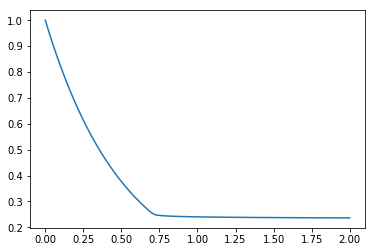

In [2]:
from neuron import h, rxd
from matplotlib import pyplot as plt
h.load_file('stdrun.hoc')

soma = h.Section(name='soma')
cyt = rxd.Region([soma], name='cyt', nrn_region='i')
ip3 = rxd.Species(cyt, name='ip3', charge=0)
k = 2 # degradation rate
threshold = 0.25 # mM... called 'a' in f(x)
m = 100 # steepness of switch
degradation_switch = (1 + rxd.rxdmath.tanh((ip3 - threshold) * 2 * m)) / 2
degradation = rxd.Rate(ip3, -k * ip3 * degradation_switch)

# prior to NEURON 7.7, this first finitialize is necessary for the pointers to exist below
h.finitialize(-65)

t = h.Vector()
ip3_conc = h.Vector()
t.record(h._ref_t)
ip3_conc.record(soma(0.5)._ref_ip3i)

h.finitialize(-65)
h.continuerun(2)

plt.plot(t, ip3_conc)
plt.show()